# TRUMP ANAL

### TODO:
- clean up tokenizing
- check out bi-lstm
- predict current tweets
- individual validation
- @potus tweets

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import string
import pandas as pd
import gensim
from sklearn.model_selection import train_test_split
from io import StringIO
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers 
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM
from keras.layers.core import Activation, Dropout, Dense

MAX_WORDS = 15000

Using TensorFlow backend.


### Merge Embedding Files

In [79]:
with open("glove.6B.100d.txt", "w+") as output:
    for i in range(0,8):
        print("Writing embeddings_" + str(i))
        with open("embeddings/embeddings_"+str(i)) as part:
            output.write("".join(part.readlines()))
            
print("Done!")

Writing embeddings_0
Writing embeddings_1
Writing embeddings_2
Writing embeddings_3
Writing embeddings_4
Writing embeddings_5
Writing embeddings_6
Writing embeddings_7
Done!


### Prepare Labels

In [3]:
df = pd.read_json("trump_tweets_11_17.json") # read json
replacement_dict = {"Twitter for iPhone": 1, "Twitter for Android": 0}
df = df.replace(to_replace=replacement_dict)   # replace labels with 1s and 0s
df = df[df.source.apply(lambda x: type(x) == int)]  # remove tweets from other sources
df = df.sample(frac=1)

### Split into training and testing

In [4]:
all_texts = df.sample(frac=1, random_state=0) # random sampling with reproducibility

X_train, X_test, y_train, y_test = train_test_split(
    all_texts['text'], 
    all_texts['source'], 
    test_size=0.20, 
    random_state=42)

In [5]:
all_texts['text'][0]

'.@SteveScalise blew the nasty &amp; obnoxious Chris Wallace (will never be his father, Mike!) away on Chris’s lowest rated (unless I’m on) morning show. This kind of dumb and unfair interview would never have happened in the @FoxNews past. Great job Steve!'

### Tokenize Text for Embedding Layer

In [6]:
#create word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# convert text to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# tokenizer dictionary
dictionary = tokenizer.word_index

In [7]:
#length of current dictionary vocab
vocab_size = len(tokenizer.word_index) + 1

maxlen = 65

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### construct embeddings using a glove model

In [8]:
embeddings_dictionary = dict()

#file is too large to store on git, must download and place in folder manually
glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [9]:
#create embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [10]:
vocab_size == len(embedding_matrix)

True

# Feed Forward Network

In [10]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 65, 100)           2444600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 6500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6501      
Total params: 2,451,101
Trainable params: 6,501
Non-trainable params: 2,444,600
_________________________________________________________________
None


In [12]:
ffn_history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

Train on 11903 samples, validate on 2976 samples
Epoch 1/15
11903/11903 [==============================] - 0s 42us/step - loss: 0.4006 - acc: 0.7989 - val_loss: 0.3455 - val_acc: 0.8293
Epoch 2/15
11903/11903 [==============================] - 0s 14us/step - loss: 0.3138 - acc: 0.8522 - val_loss: 0.3187 - val_acc: 0.8454
Epoch 3/15
11903/11903 [==============================] - 0s 14us/step - loss: 0.2879 - acc: 0.8650 - val_loss: 0.3140 - val_acc: 0.8498
Epoch 4/15
11903/11903 [==============================] - 0s 13us/step - loss: 0.2717 - acc: 0.8753 - val_loss: 0.3056 - val_acc: 0.8522
Epoch 5/15
11903/11903 [==============================] - 0s 13us/step - loss: 0.2604 - acc: 0.8813 - val_loss: 0.3086 - val_acc: 0.8508
Epoch 6/15
11903/11903 [==============================] - 0s 12us/step - loss: 0.2517 - acc: 0.8873 - val_loss: 0.3051 - val_acc: 0.8525
Epoch 7/15
11903/11903 [==============================] - 0s 12us/step - loss: 0.2466 - acc: 0.8915 - val_loss: 0.3066 - val_acc:

In [13]:
ffn_score = model.evaluate(X_test, y_test, verbose=1)

3720/3720 [==============================] - 0s 28us/step


In [14]:
print("Test Score:", ffn_score[0])
print("Test Accuracy:", ffn_score[1])

Test Score: 0.3247399728785279
Test Accuracy: 0.8408601880073547


### BALANCING

In [11]:
from keras.utils import to_categorical
from imblearn.keras import balanced_batch_generator
from imblearn.under_sampling import NearMiss

In [12]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [57]:
model_balance = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_balance.add(embedding_layer)

model_balance.add(Flatten())
model_balance.add(Dense(2, activation='sigmoid'))

In [58]:
model_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model_balance.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 65, 100)           2453200   
_________________________________________________________________
flatten_2 (Flatten)          (None, 6500)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 13002     
Total params: 2,466,202
Trainable params: 13,002
Non-trainable params: 2,453,200
_________________________________________________________________
None


In [59]:
training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, sampler=NearMiss(), batch_size=128, random_state=42)

In [60]:
balanced_history_ffn = model_balance.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 0s 4ms/step - loss: 0.5320 - acc: 0.7358 - val_loss: 0.5340 - val_acc: 0.7228
Epoch 2/50
54/54 [==============================] - 0s 3ms/step - loss: 0.4149 - acc: 0.8194 - val_loss: 0.4818 - val_acc: 0.7629
Epoch 3/50
54/54 [==============================] - 0s 2ms/step - loss: 0.3710 - acc: 0.8452 - val_loss: 0.4675 - val_acc: 0.7784
Epoch 4/50
54/54 [==============================] - 0s 2ms/step - loss: 0.3449 - acc: 0.8557 - val_loss: 0.4630 - val_acc: 0.7828
Epoch 5/50
54/54 [==============================] - 0s 2ms/step - loss: 0.3284 - acc: 0.8639 - val_loss: 0.4567 - val_acc: 0.7902
Epoch 6/50
54/54 [==============================] - 0s 2ms/step - loss: 0.3137 - acc: 0.8707 - val_loss: 0.4551 - val_acc: 0.7944
Epoch 7/50
54/54 [==============================] - 0s 2ms/step - loss: 0.3020 - acc: 0.8739 - val_loss: 0.4535 - val_acc: 0.7969
Epoch 8/50
54/54 [==============================] - 0s 2ms/step - loss: 0.2918 - acc: 0.87

In [61]:
model_balance.evaluate(X_test, y_test)

3720/3720 [==============================] - 0s 25us/step


[0.5636101716949093, 0.8115591406822205]

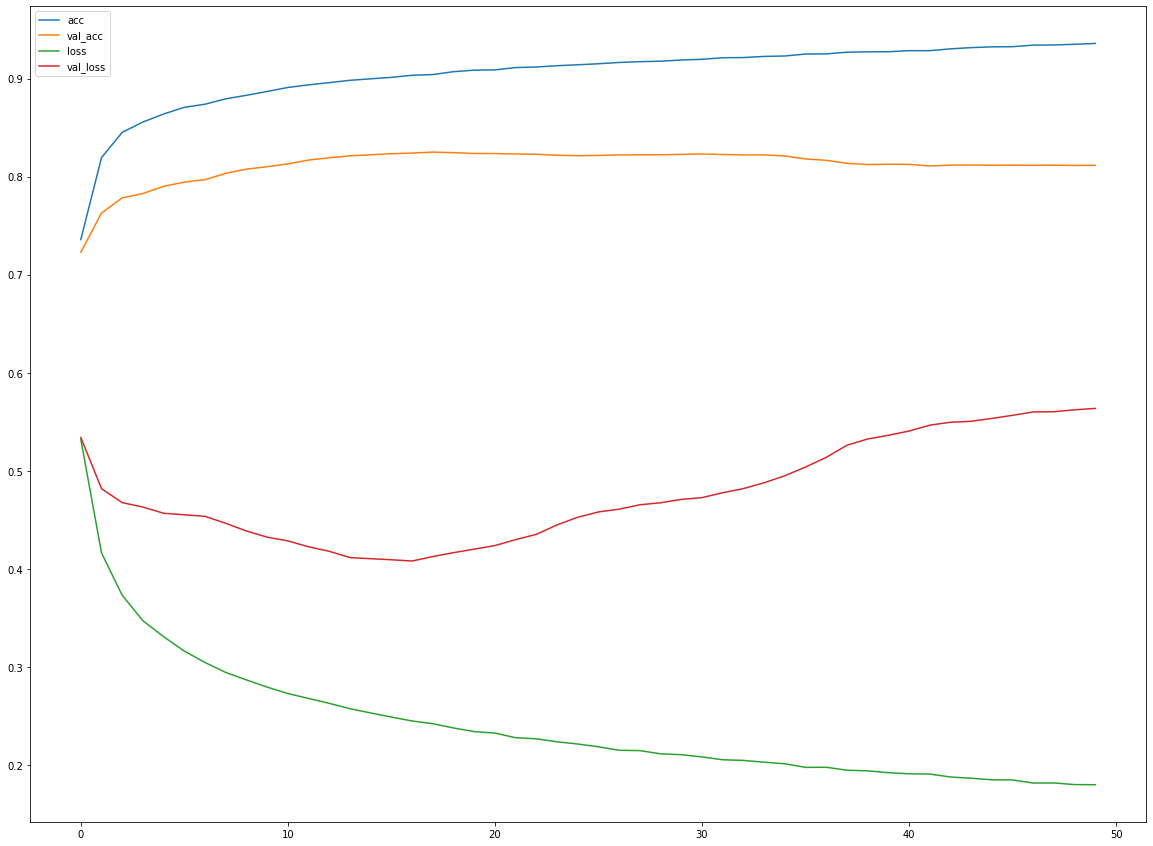

In [62]:
plt.figure(figsize=(20,15))
plt.plot(balanced_history_ffn.history['acc'])
plt.plot(balanced_history_ffn.history['val_acc'])
plt.plot(balanced_history_ffn.history['loss'])
plt.plot(balanced_history_ffn.history['val_loss'])
plt.legend(['acc','val_acc','loss','val_loss'])
plt.show()

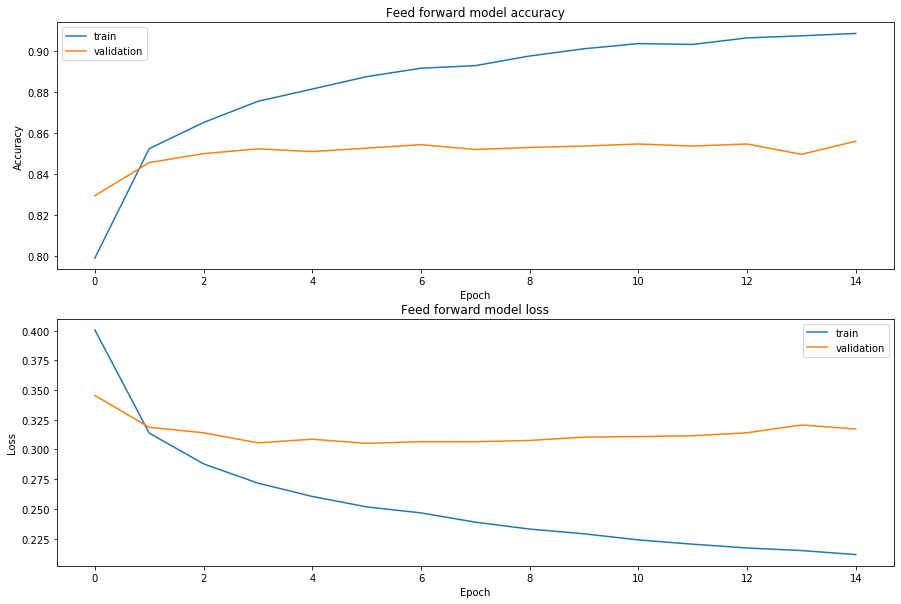

In [15]:
# plots
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(ffn_history.history['acc'])
plt.plot(ffn_history.history['val_acc'])
plt.title('Feed forward model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(ffn_history.history['loss'])
plt.plot(ffn_history.history['val_loss'])
plt.title('Feed forward model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

# CNN

In [19]:
cnn = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn.add(embedding_layer)

cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [20]:
print(cnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 100)           2444600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 61, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,508,857
Trainable params: 64,257
Non-trainable params: 2,444,600
_________________________________________________________________
None


In [21]:
cnn_history = cnn.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

cnn_score = cnn.evaluate(X_test, y_test, verbose=1)

Train on 11903 samples, validate on 2976 samples
Epoch 1/15
11903/11903 [==============================] - 2s 188us/step - loss: 0.3972 - acc: 0.8235 - val_loss: 0.3288 - val_acc: 0.8552
Epoch 2/15
11903/11903 [==============================] - 0s 33us/step - loss: 0.2872 - acc: 0.8794 - val_loss: 0.3017 - val_acc: 0.8760
Epoch 3/15
11903/11903 [==============================] - 0s 33us/step - loss: 0.2373 - acc: 0.9050 - val_loss: 0.2805 - val_acc: 0.8847
Epoch 4/15
11903/11903 [==============================] - 0s 33us/step - loss: 0.1978 - acc: 0.9291 - val_loss: 0.2713 - val_acc: 0.8905
Epoch 5/15
11903/11903 [==============================] - 0s 36us/step - loss: 0.1703 - acc: 0.9389 - val_loss: 0.2622 - val_acc: 0.8925
Epoch 6/15
11903/11903 [==============================] - 0s 34us/step - loss: 0.1365 - acc: 0.9593 - val_loss: 0.2588 - val_acc: 0.8925
Epoch 7/15
11903/11903 [==============================] - 0s 35us/step - loss: 0.1119 - acc: 0.9701 - val_loss: 0.2527 - val_acc

In [22]:
print("Test Score:", cnn_score[0])
print("Test Accuracy:", cnn_score[1])

Test Score: 0.3066553061367363
Test Accuracy: 0.8806451559066772


### BALANCING CNN

In [43]:
cnn_balance = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_balance.add(embedding_layer)

cnn_balance.add(Conv1D(128, 5, activation='relu'))
cnn_balance.add(GlobalMaxPooling1D())
cnn_balance.add(Dense(2, activation='sigmoid'))
cnn_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [44]:
cnn_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(cnn_balance.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 65, 100)           2453200   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 61, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 2,517,586
Trainable params: 64,386
Non-trainable params: 2,453,200
_________________________________________________________________
None


In [45]:
training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, sampler=NearMiss(), batch_size=128, random_state=42)

In [46]:
balanced_history_cnn = cnn_balance.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, validation_data=(X_test, y_test))

Epoch 1/40
54/54 [==============================] - 0s 7ms/step - loss: 0.4474 - acc: 0.7961 - val_loss: 0.6832 - val_acc: 0.5956
Epoch 2/40
54/54 [==============================] - 0s 6ms/step - loss: 0.3249 - acc: 0.8678 - val_loss: 0.6180 - val_acc: 0.6585
Epoch 3/40
54/54 [==============================] - 0s 5ms/step - loss: 0.2696 - acc: 0.8929 - val_loss: 0.6292 - val_acc: 0.6687
Epoch 4/40
54/54 [==============================] - 0s 5ms/step - loss: 0.2298 - acc: 0.9124 - val_loss: 0.6438 - val_acc: 0.6724
Epoch 5/40
54/54 [==============================] - 0s 5ms/step - loss: 0.1976 - acc: 0.9270 - val_loss: 0.6535 - val_acc: 0.6790
Epoch 6/40
54/54 [==============================] - 0s 5ms/step - loss: 0.1685 - acc: 0.9434 - val_loss: 0.6969 - val_acc: 0.6710
Epoch 7/40
54/54 [==============================] - 0s 5ms/step - loss: 0.1429 - acc: 0.9572 - val_loss: 0.7317 - val_acc: 0.6692
Epoch 8/40
54/54 [==============================] - 0s 5ms/step - loss: 0.1205 - acc: 0.96

In [47]:
cnn_balance.evaluate(X_test, y_test)

3720/3720 [==============================] - 0s 33us/step


[1.6045937377919433, 0.6553763151168823]

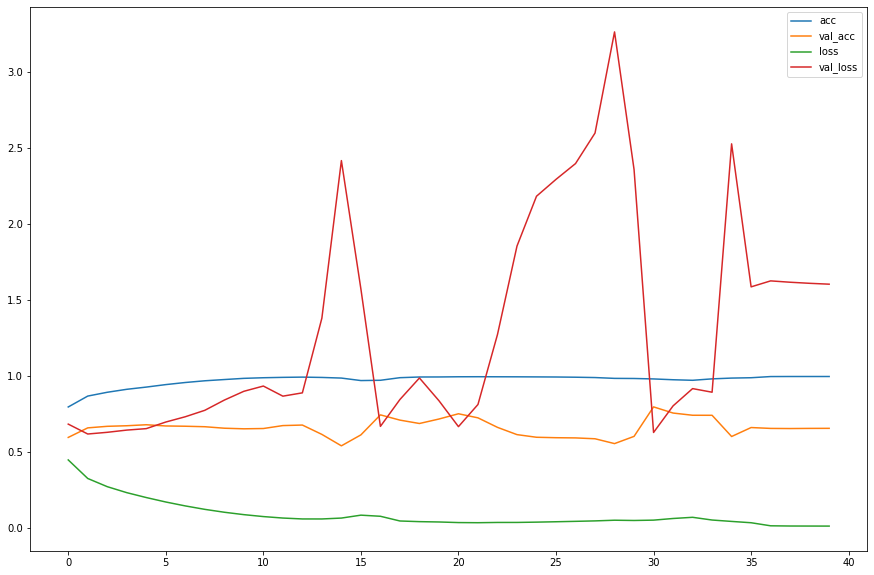

In [49]:
plt.figure(figsize=(15,10))
plt.plot(balanced_history_cnn.history['acc'])
plt.plot(balanced_history_cnn.history['val_acc'])
plt.plot(balanced_history_cnn.history['loss'])
plt.plot(balanced_history_cnn.history['val_loss'])
plt.legend(['acc','val_acc','loss','val_loss'])
plt.show()

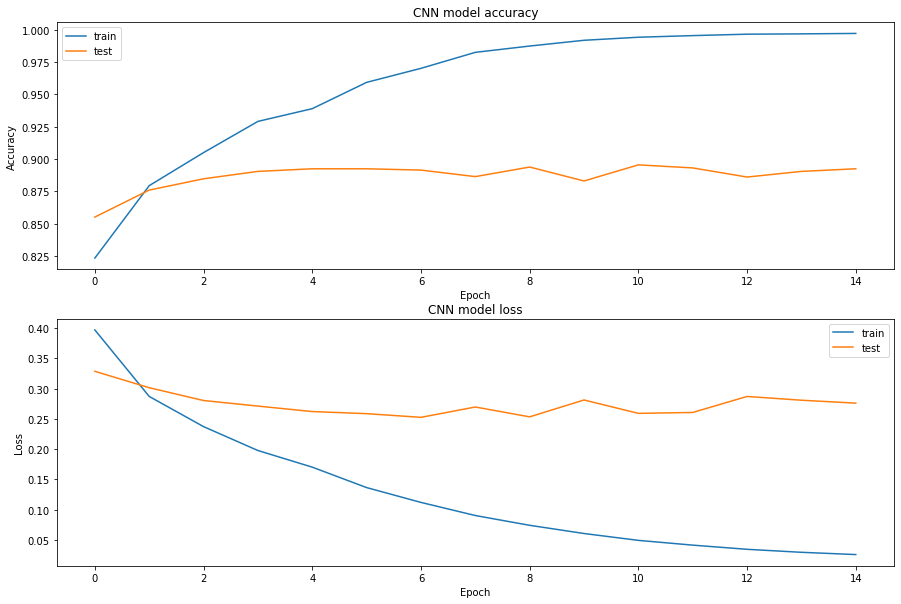

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('CNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper left')

plt.subplot(2,1,2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

# LSTM model

In [24]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [25]:
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 65, 100)           2444600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,561,977
Trainable params: 117,377
Non-trainable params: 2,444,600
_________________________________________________________________
None


In [26]:
lstm_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)

Train on 11903 samples, validate on 2976 samples
Epoch 1/15
11903/11903 [==============================] - 5s 418us/step - loss: 0.4850 - acc: 0.7584 - val_loss: 0.4415 - val_acc: 0.7147
Epoch 2/15
11903/11903 [==============================] - 4s 331us/step - loss: 0.3901 - acc: 0.7974 - val_loss: 0.3616 - val_acc: 0.8306
Epoch 3/15
11903/11903 [==============================] - 4s 315us/step - loss: 0.3356 - acc: 0.8341 - val_loss: 0.3238 - val_acc: 0.8374
Epoch 4/15
11903/11903 [==============================] - 4s 323us/step - loss: 0.3066 - acc: 0.8507 - val_loss: 0.2903 - val_acc: 0.8616
Epoch 5/15
11903/11903 [==============================] - 4s 317us/step - loss: 0.2932 - acc: 0.8596 - val_loss: 0.2861 - val_acc: 0.8653
Epoch 6/15
11903/11903 [==============================] - 4s 331us/step - loss: 0.2775 - acc: 0.8642 - val_loss: 0.2882 - val_acc: 0.8646
Epoch 7/15
11903/11903 [==============================] - 4s 328us/step - loss: 0.2662 - acc: 0.8776 - val_loss: 0.2859 - v

In [27]:
print("Test Score:", lstm_score[0])
print("Test Accuracy:", lstm_score[1])

Test Score: 0.2922221370922622
Test Accuracy: 0.8575268983840942


### BALANCE

In [22]:
lstm_model_balance = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model_balance.add(embedding_layer)
lstm_model_balance.add(LSTM(128))

lstm_model_balance.add(Dense(2, activation='sigmoid'))
lstm_model_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [23]:
balanced_history_lstm = lstm_model_balance.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 3s 57ms/step - loss: 0.5738 - acc: 0.7050 - val_loss: 0.7700 - val_acc: 0.5663
Epoch 2/50
54/54 [==============================] - 2s 42ms/step - loss: 0.4196 - acc: 0.8129 - val_loss: 0.7590 - val_acc: 0.6194
Epoch 3/50
54/54 [==============================] - 2s 41ms/step - loss: 0.3575 - acc: 0.8462 - val_loss: 0.8680 - val_acc: 0.6063
Epoch 4/50
54/54 [==============================] - 2s 41ms/step - loss: 0.3249 - acc: 0.8595 - val_loss: 0.8752 - val_acc: 0.6069
Epoch 5/50
54/54 [==============================] - 2s 41ms/step - loss: 0.3075 - acc: 0.8725 - val_loss: 1.1086 - val_acc: 0.5704
Epoch 6/50
54/54 [==============================] - 2s 42ms/step - loss: 0.2996 - acc: 0.8740 - val_loss: 1.0233 - val_acc: 0.5817
Epoch 7/50
54/54 [==============================] - 2s 41ms/step - loss: 0.2851 - acc: 0.8822 - val_loss: 1.1798 - val_acc: 0.5590
Epoch 8/50
54/54 [==============================] - 2s 42ms/step - loss: 0.2787 - a

In [24]:
lstm_model_balance.evaluate(X_test, y_test)

3720/3720 [==============================] - 2s 459us/step


[1.0761600080356803, 0.7038978338241577]

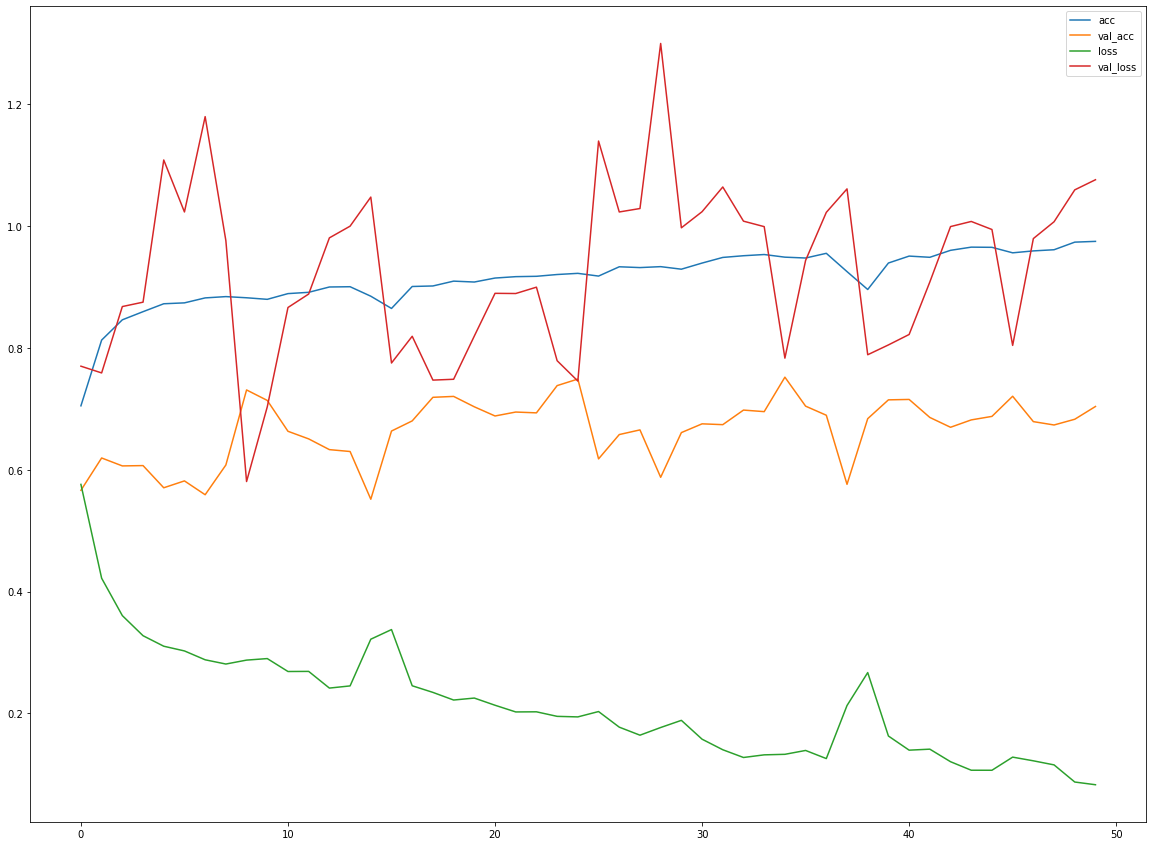

In [29]:
plt.figure(figsize=(20,15))
plt.plot(balanced_history_lstm.history['acc'])
plt.plot(balanced_history_lstm.history['val_acc'])
plt.plot(balanced_history_lstm.history['loss'])
plt.plot(balanced_history_lstm.history['val_loss'])
plt.legend(['acc','val_acc','loss','val_loss'])
plt.show()

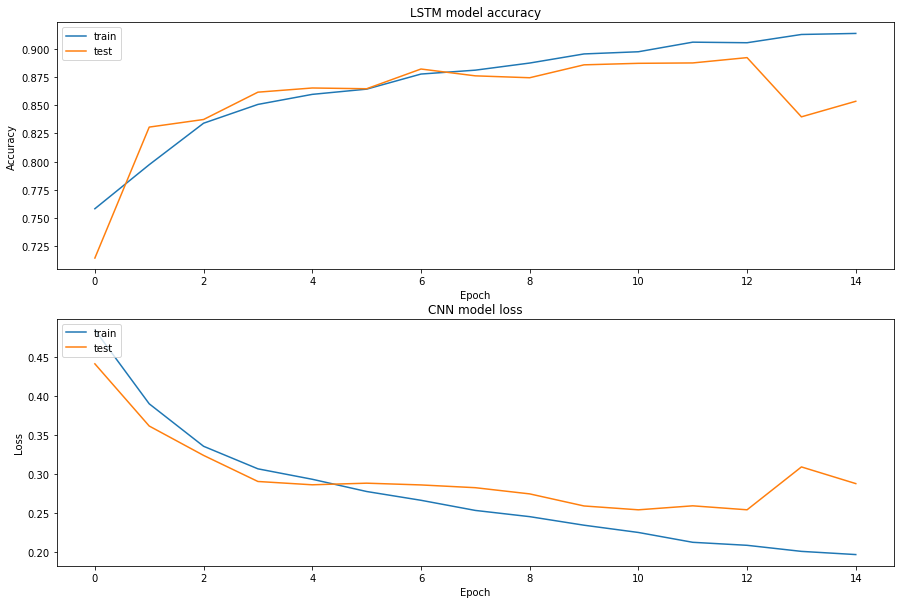

In [28]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])
plt.title('LSTM model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [29]:
lstm_model.predict(X_test)[2]

array([0.52488476], dtype=float32)